In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import random
import os
from tensorflow.keras.models import load_model

FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

/home/ma-user/anaconda3/envs/TensorFlow-2.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
filenames = os.listdir('train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})

In [3]:
df.head()

,category,filename
0,1,dog.6850.jpg
1,1,dog.11448.jpg
2,1,dog.1151.jpg
3,1,dog.6466.jpg
4,1,dog.8813.jpg


In [4]:
df.tail()

,category,filename
24995,1,dog.8245.jpg
24996,0,cat.9845.jpg
24997,1,dog.1573.jpg
24998,1,dog.9924.jpg
24999,1,dog.1053.jpg


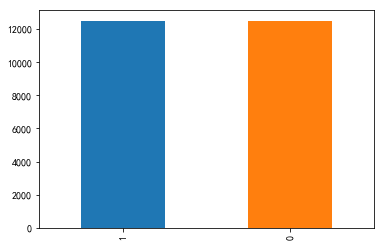

In [5]:
df['category'].value_counts().plot.bar()

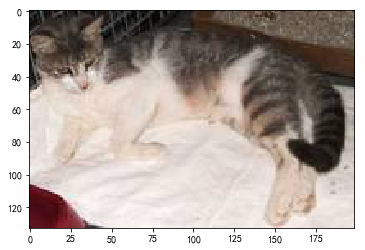

In [6]:
sample = random.choice(filenames)
image = load_img('train/'+sample)
plt.imshow(image)

In [7]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})

In [8]:
train_df, validate_df = train_test_split(df, test_size = 0.2, random_state=42)
train_df = train_df.reset_index(drop=True)#把train_df中df保留下来的不再连续的索引删除，并填上新的索引
validate_df = validate_df.reset_index(drop=True)

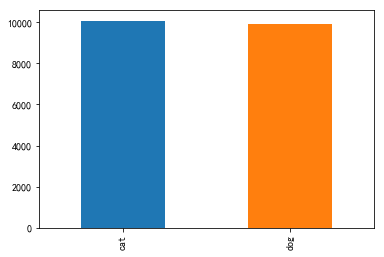

In [9]:
train_df['category'].value_counts().plot.bar()

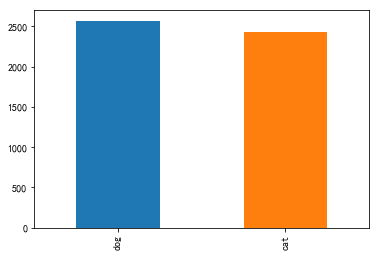

In [10]:
validate_df['category'].value_counts().plot.bar()

In [11]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=128

In [12]:
train_datagen = ImageDataGenerator(#含参初始化一个ImageDataGenerator，这是一个关于批量生成数据的类
    rotation_range = 5,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)
train_generator = train_datagen.flow_from_dataframe(#在ImageDataGenerator类中有一个flow_from_dataframe的方法，
    train_df,
    "train/",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [13]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "train/",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [14]:
example_df = train_df.sample(n=1).reset_index(drop = True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "train/",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 1 validated image filenames belonging to 1 classes.


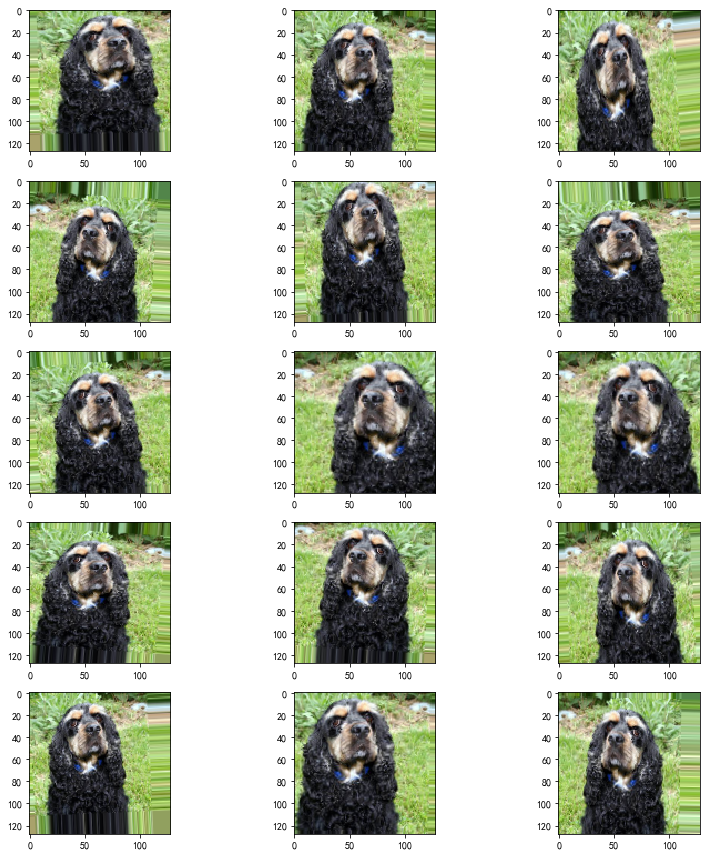

In [15]:
plt.figure(figsize = (12,12))
for i in range(0, 15):
    plt.subplot(5,3,i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,Activation,BatchNormalization

In [17]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS),padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(2,activation = 'softmax'))

In [18]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'sgd',metrics = ['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [21]:
earlystop = EarlyStopping(patience=10)

In [22]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 5,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.0001
)

In [23]:
callbacks = [earlystop, learning_rate_reduction]

In [24]:
FAST_RUN = False
epochs = 3 if FAST_RUN else 20
history = model.fit(train_generator,
                    steps_per_epoch = total_train//batch_size,
                    epochs = epochs,
                    validation_data = validation_generator,
                    validation_steps = total_validate//batch_size,
                    callbacks = callbacks,
                    workers = 12
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 156 steps, validate for 39 steps
Epoch 1/20
156/156 [==============================] - 78s 501ms/step - loss: 0.7487 - accuracy: 0.6462 - val_loss: 0.9776 - val_accuracy: 0.4892
Epoch 2/20
156/156 [==============================] - 48s 308ms/step - loss: 0.5722 - accuracy: 0.7047 - val_loss: 0.9169 - val_accuracy: 0.5811
Epoch 3/20
156/156 [==============================] - 48s 307ms/step - loss: 0.5387 - accuracy: 0.7258 - val_loss: 0.6229 - val_accuracy: 0.6865
Epoch 4/20
156/156 [==============================] - 47s 304ms/step - loss: 0.5191 - accuracy: 0.7394 - val_loss: 0.5718 - val_accuracy: 0.7228
Epoch 5/20
156/156 [==============================] - 48s 309ms/step - loss: 0.4966 - accuracy: 0.7554 - val_loss: 0.5054 - val_accuracy: 0.7654
Epoch 6/20
156/156 [==============================] - 48s 307ms/step - loss: 0.4813 - accuracy: 0.7657 - val_loss: 0.4764 - val_accuracy: 0.7768
Epoch 7/20
156/156 [=================

In [25]:
model.save_weights('model.h5')

In [26]:
model.save('model_total.h5')

In [27]:
history.history

{'accuracy': [0.6461856,
  0.7047101,
  0.7257951,
  0.739382,
  0.75538445,
  0.76570046,
  0.7720411,
  0.78074676,
  0.7876409,
  0.7936292,
  0.7970008,
  0.8052033,
  0.80736715,
  0.81174517,
  0.81446254,
  0.81763285,
  0.8175322,
  0.82578504,
  0.82221216,
  0.8299114],
 'loss': [0.7480757900674178,
  0.5722273873246234,
  0.5389822297242145,
  0.5185469262265928,
  0.49674976635094426,
  0.48125785512432767,
  0.4670982218786906,
  0.45947398070167994,
  0.4484106306100621,
  0.44038528933425264,
  0.4351797451335643,
  0.42097673803903823,
  0.4164410111600842,
  0.40527046830565844,
  0.4014195532998409,
  0.3972513063326358,
  0.39760800548221753,
  0.3867543781245196,
  0.38692423206980486,
  0.37849852178791676],
 'lr': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01],
 'val_accuracy': [0.48918268,
  0.5811298,
  0.6864984,
  0.7227564,
  0.76542467,
  0.7768429

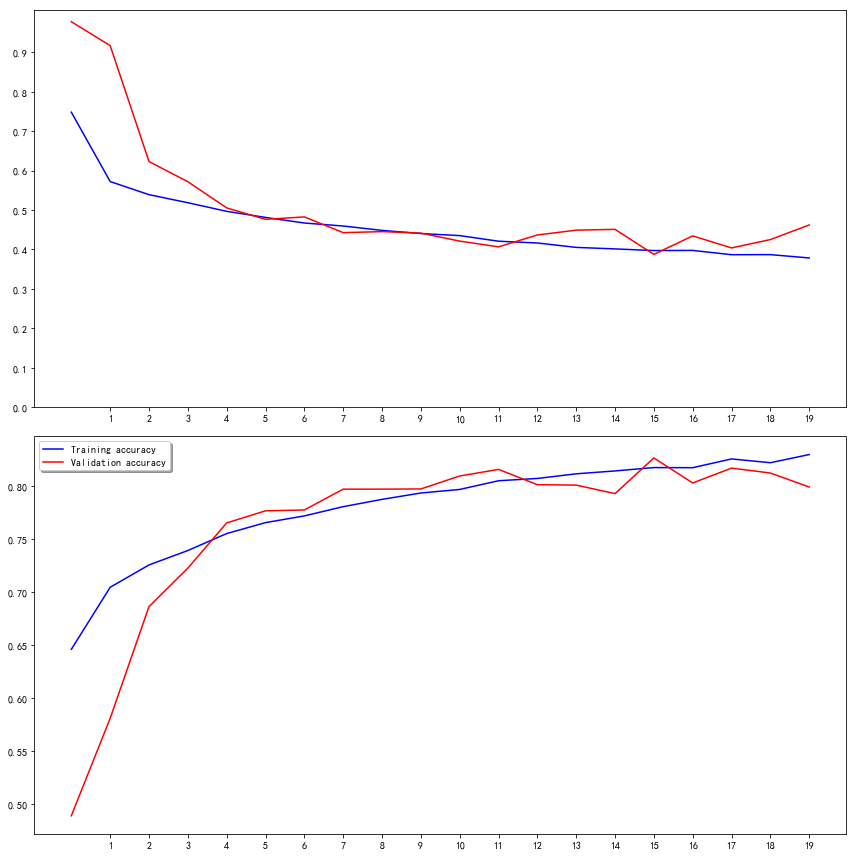

In [28]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.plot(history.history['loss'],color = 'b',label = "Training loss")
ax1.plot(history.history['val_loss'],color = 'r',label = "validation loss")
ax1.set_xticks(np.arange(1,epochs,1))
ax1.set_yticks(np.arange(0,1,0.1))

ax2.plot(history.history['accuracy'],color = 'b',label = "Training accuracy")
ax2.plot(history.history['val_accuracy'],color = 'r',label = "Validation accuracy")
ax2.set_xticks(np.arange(1,epochs,1))

lengend = plt.legend(loc = 'best',shadow = True)
plt.tight_layout()
plt.show()

In [29]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename':test_filenames
})
nb_samples = test_df.shape[0]


In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "test1/",
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 12500 validated image filenames.


In [31]:
predict = model.predict(test_generator,
                        steps = np.ceil(nb_samples/batch_size),
                        workers = 12
                       )

In [32]:
test_df['category'] = np.argmax(predict,axis = -1)

In [33]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [34]:
test_df['category'] = test_df['category'].replace({'dog':1,'cat':0})

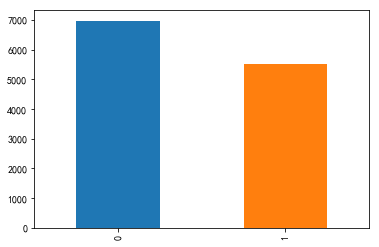

In [35]:
test_df['category'].value_counts().plot.bar()

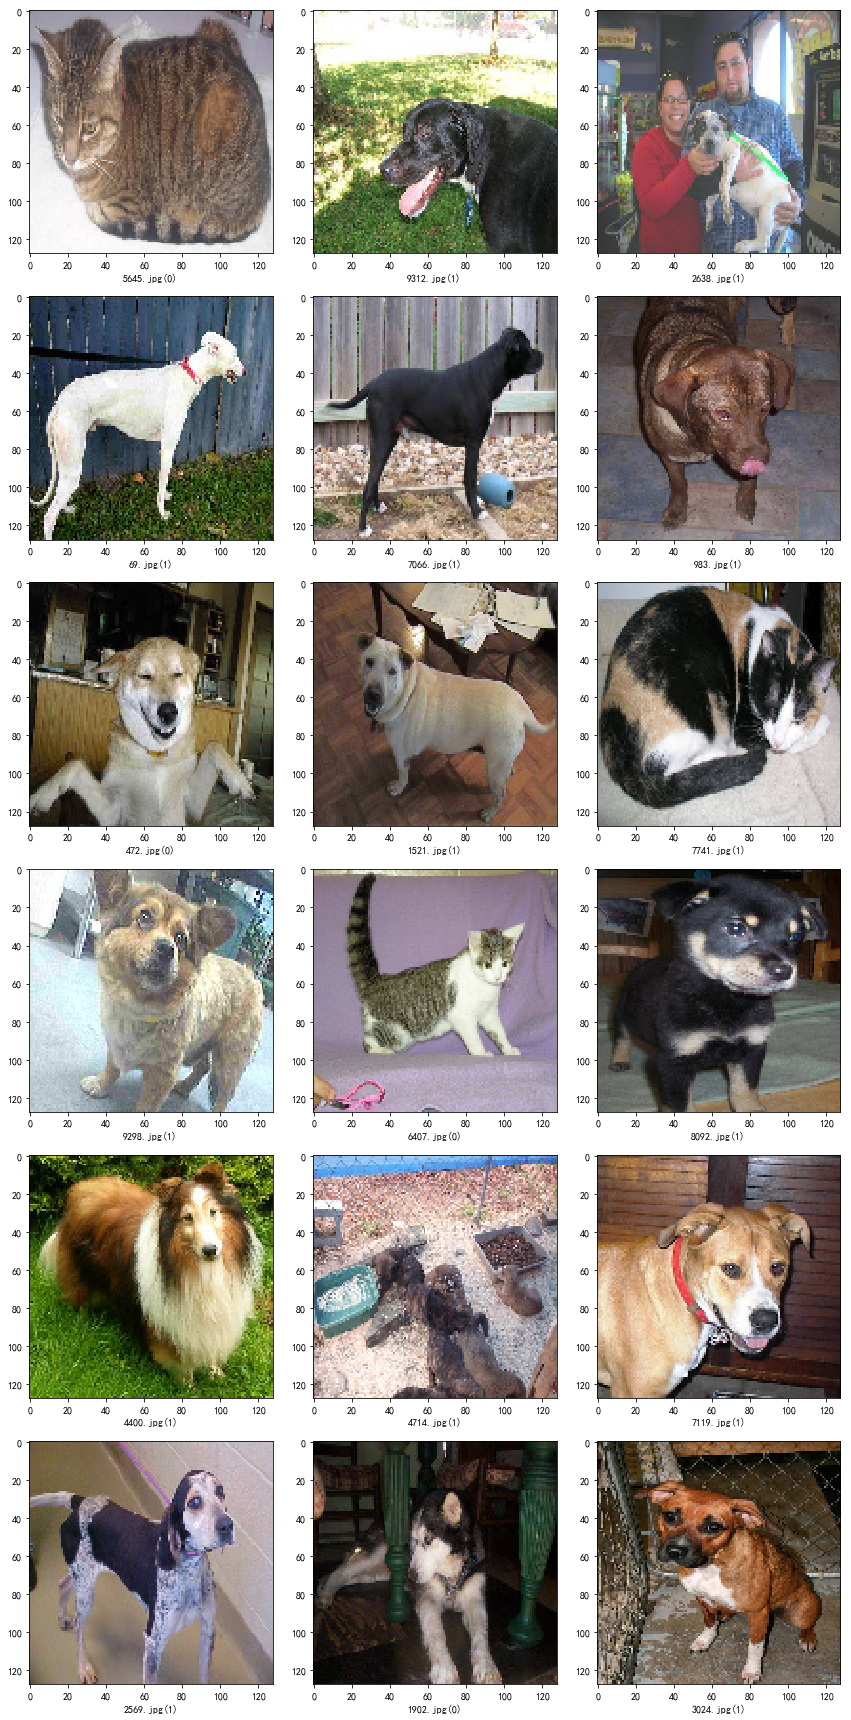

In [36]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize = (12,24))
for index,row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename,target_size = IMAGE_SIZE)
    plt.subplot(6,3,index+1)
    plt.imshow(img)
    plt.xlabel(filename+'('+"{}".format(category)+ ')' )
plt.tight_layout()
plt.show()

In [37]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import random
import os
from tensorflow.keras.models import load_model

In [38]:
model_total = load_model("model_total.h5")

In [39]:
history = model_total.fit(train_generator,
                        steps_per_epoch = total_train//batch_size,
                        epochs = 10,
                        validation_data = validation_generator,
                        validation_steps = total_validate//batch_size,
                        callbacks = callbacks,
                        workers = 12
                        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 156 steps, validate for 39 steps
Epoch 1/10
156/156 [==============================] - 48s 309ms/step - loss: 0.3751 - accuracy: 0.8339 - val_loss: 0.4360 - val_accuracy: 0.8117
Epoch 2/10
156/156 [==============================] - 47s 304ms/step - loss: 0.3658 - accuracy: 0.8353 - val_loss: 0.3716 - val_accuracy: 0.8371
Epoch 3/10
156/156 [==============================] - 48s 306ms/step - loss: 0.3671 - accuracy: 0.8343 - val_loss: 0.3770 - val_accuracy: 0.8355
Epoch 4/10
156/156 [==============================] - 48s 305ms/step - loss: 0.3630 - accuracy: 0.8395 - val_loss: 0.4243 - val_accuracy: 0.8079
Epoch 5/10
156/156 [==============================] - 47s 304ms/step - loss: 0.3566 - accuracy: 0.8422 - val_loss: 0.4136 - val_accuracy: 0.8213
Epoch 6/10
156/156 [==============================] - 47s 302ms/step - loss: 0.3522 - accuracy: 0.8426 - val_loss: 0.3665 - val_accuracy: 0.8431
Epoch 7/10
156/156 [=================

In [40]:
history.history

{'accuracy': [0.83388686,
  0.8352959,
  0.83428943,
  0.83947265,
  0.84224033,
  0.8425926,
  0.84198874,
  0.84777576,
  0.84656805,
  0.84978867],
 'loss': [0.3739030224881502,
  0.3653379420535384,
  0.36693225952162256,
  0.3628986508566016,
  0.3567356236890894,
  0.35233864754486394,
  0.35272064809829906,
  0.3470734436538868,
  0.34440541651321877,
  0.340921453807665],
 'lr': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 'val_accuracy': [0.81169873,
  0.8371394,
  0.83553684,
  0.8078926,
  0.8213141,
  0.84314907,
  0.8407452,
  0.84234774,
  0.8307292,
  0.8327324],
 'val_loss': [0.43603477340478164,
  0.3715895062837845,
  0.37704376532481265,
  0.42426110001710743,
  0.4136006228434734,
  0.3664733752226218,
  0.37429217191842884,
  0.37885790528395236,
  0.39542314906915027,
  0.37730859793149507]}

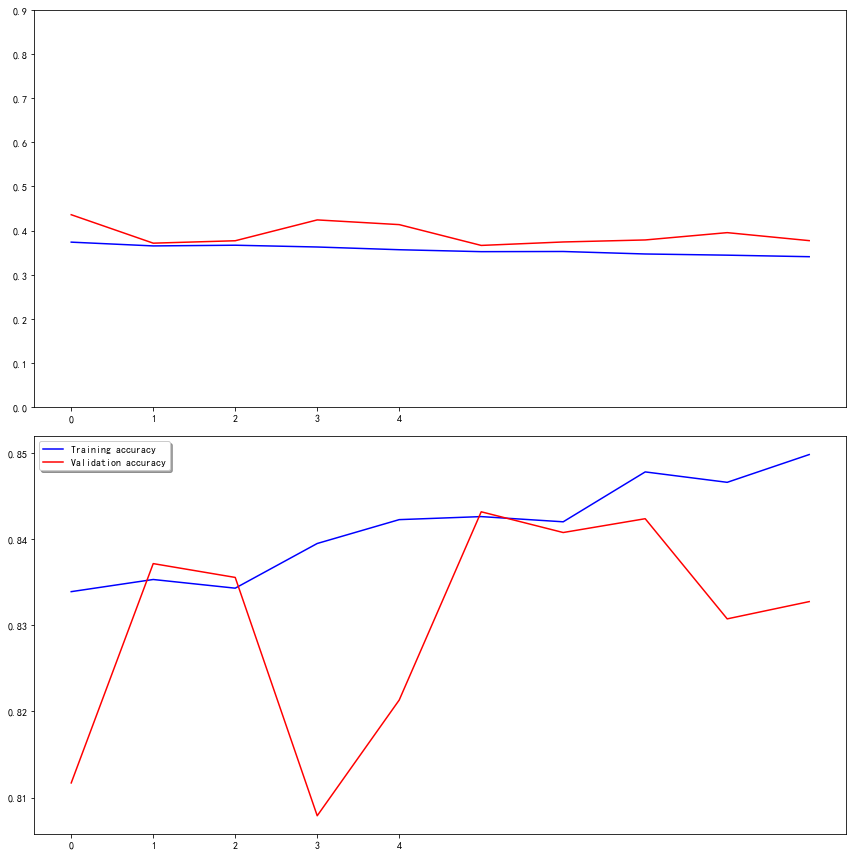

In [41]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.plot(history.history['loss'],color = 'b',label = "Training loss")
ax1.plot(history.history['val_loss'],color = 'r',label = "validation loss")
ax1.set_xticks(np.arange(0,5,1))
ax1.set_yticks(np.arange(0,1,0.1))

ax2.plot(history.history['accuracy'],color = 'b',label = "Training accuracy")
ax2.plot(history.history['val_accuracy'],color = 'r',label = "Validation accuracy")
ax2.set_xticks(np.arange(0,5,1))

lengend = plt.legend(loc = 'best',shadow = True)
plt.tight_layout()
plt.show()
